In [ ]:
import numpy as np
import pandas as pd
import pyarrow
import os
from os import listdir
from os.path import isfile, join
from time import time
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import TensorDataset, DataLoader, random_split,DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mypath = "/content/drive/MyDrive/the-future-crop-challenge"

In [ ]:
USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device('cuda:0')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load train

In [ ]:
def get_region(row):
    if -125 <= row['lon'] <= -66 and 24 <= row['lat'] <= 50:
        return 'USA'
    elif -75 <= row['lon'] <= -35 and -40 <= row['lat'] <= -10:
        return 'South America'
    elif -10 <= row['lon'] <= 50 and 35 <= row['lat'] <= 60:
        return 'Europe'
    else:
        return 'Other'

In [ ]:
def load(crop,mode,data_dir):
    tasmax = pd.read_parquet(os.path.join(data_dir, "tasmax_{}_{}.parquet".format(crop,mode)))
    tasmin = pd.read_parquet(os.path.join(data_dir, "tasmin_{}_{}.parquet".format(crop,mode)))
    tas = pd.read_parquet(os.path.join(data_dir, "tas_{}_{}.parquet".format(crop,mode)))
    pr = pd.read_parquet(os.path.join(data_dir, "pr_{}_{}.parquet".format(crop,mode)))
    rsds = pd.read_parquet(os.path.join(data_dir, "rsds_{}_{}.parquet".format(crop,mode)))
    soil_co2 = pd.read_parquet(os.path.join(data_dir, "soil_co2_{}_{}.parquet".format(crop,mode)))

    if mode == 'train':
        yield_ = pd.read_parquet(os.path.join(data_dir, "{}_solutions_{}.parquet".format(mode,crop)))
        yield_ = yield_.values.astype(np.float32)

    if mode == 'test':
        yield_ = None

    climate = np.concatenate([
        tas.values[:, 5:,np.newaxis].astype(np.float32),
        tasmax.values[:, 5:,np.newaxis].astype(np.float32),
        tasmin.values[:, 5:,np.newaxis].astype(np.float32),
        pr.values[:, 5:,np.newaxis].astype(np.float32),
        rsds.values[:, 5:,np.newaxis].astype(np.float32),
    ], axis=2)
    return(climate,yield_,soil_co2)

In [ ]:
def get_training_dataloader(crop, mode, mypath, region, static_var, detrend=True):
    (climate, yield_label, soil) = load(crop, mode, mypath)

    # Reshape and calculate mean and std along grouped axis
    climate_mean = climate.reshape(climate.shape[0], 8, 30, 5).mean(axis=2)
    climate_sd = climate.reshape(climate.shape[0], 8, 30, 5).std(axis=2)

    GPP = np.maximum(climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,3] - 10, 0).sum(axis=2, keepdims=True).cumsum(axis=1)
    heat_stress_day = (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,1] > 30).sum(axis=2, keepdims=True).cumsum(axis=1)
    frost_days = (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,2] < 0).sum(axis=2, keepdims=True).cumsum(axis=1)

    climate_stats = np.concatenate([climate_sd, climate_mean, GPP, heat_stress_day, frost_days], axis=2)

    # Annual mean
    annual_df = pd.DataFrame(climate.mean(axis=1), columns=['tas', 'tasmax', 'tasmin', 'pr', 'rsds'])
    soil = soil.reset_index(drop=True)
    soil = pd.concat([annual_df, soil], axis=1)

    soil['region'] = soil.apply(get_region, axis=1)
    soil['co2'] = soil['co2'] / 1500

    # Detrend yield
    soil['yield'] = yield_label
    grouped_mean = soil.groupby(['lon', 'lat'])['yield'].mean().reset_index()
    grouped_mean = grouped_mean.rename(columns={'yield': 'yield_mean'})
    soil = pd.merge(soil, grouped_mean, on=['lon', 'lat'])
    soil['de_yield'] = soil['yield'] - soil['yield_mean']

    # Scale input features
    climate_arr = climate_stats.reshape(-1, climate_stats.shape[2])
    scaler = StandardScaler()
    scaler.fit(climate_arr)
    scaled_climate = scaler.transform(climate_arr).reshape(climate_stats.shape)

    # Scale static features
    scaler_static = StandardScaler()
    static_arr = soil[static_var].values.astype(np.float32)
    scaler_static.fit(static_arr)
    scaled_static = scaler_static.transform(static_arr)
    scaled_static = np.concatenate([scaled_static, soil['co2'].values.reshape(-1, 1)], axis=1)

    # Convert to torch tensors
    X = torch.from_numpy(scaled_climate).float()
    X_static = torch.from_numpy(scaled_static).float()
    y = torch.from_numpy(
        soil['de_yield'].values.reshape(-1, 1) if detrend else soil['yield'].values.reshape(-1, 1)
    ).float()

    dataset = TensorDataset(X, X_static, y)

    # Filter by region
    Region_index = soil[soil['region'].isin(region)].index.values
    dataset = torch.utils.data.Subset(dataset, Region_index)
    soil = soil.loc[Region_index].reset_index(drop=True)  # Align index with Subset

    print(f"After region filtering: {len(dataset)} samples")

    # 🟨 Year-based split using real_year
    if 'real_year' not in soil.columns:
        raise ValueError("'real_year' column not found in soil dataframe.")

    val_indices = soil[soil['real_year'] == 2020].index.tolist()
    train_indices = soil[soil['real_year'] != 2020].index.tolist()

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Optional: take last 10% of train as test set
    test_split = int(0.1 * len(train_dataset))
    test_dataset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset) - test_split, len(train_dataset))))
    train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, len(train_dataset) - test_split)))

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3000, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=3000, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=3000, shuffle=False)

    print(f"Train: {len(train_loader.dataset)}, Val (2020): {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")
    return train_loader, val_loader, test_loader

# Train

In [ ]:
# Updated BiLSTMForecaster_static using custom BiLSTM from notebook.py
import torch
import torch.nn as nn

# ---- Custom LSTM definitions ----
class CustomLSTM(nn.Module):
    class _LSTM(nn.Module):
        def __init__(self, input_size, hidden_size):
            super().__init__()
            self.hidden_size = hidden_size
            self.xh2gate = nn.Linear(input_size + hidden_size, 4 * hidden_size)

        def forward(self, x_t, h_t, c_t):
            combined = torch.cat((x_t, h_t), dim=1)
            gates = self.xh2gate(combined)
            i, f, o, g = gates.chunk(4, dim=1)
            i = torch.sigmoid(i)
            f = torch.sigmoid(f)
            o = torch.sigmoid(o)
            g = torch.tanh(g)
            c_t = f * c_t + i * g
            h_t = o * torch.tanh(c_t)
            return h_t, c_t

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layers = nn.ModuleList([
            self._LSTM(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        for t in range(seq_len):
            input_t = x[:, t, :]
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.layers[layer](input_t, h[layer], c[layer])
                input_t = h[layer]
        return h[-1]

class CustomBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.forward_lstm = CustomLSTM(input_size, hidden_size, num_layers)
        self.backward_lstm = CustomLSTM(input_size, hidden_size, num_layers)

    def forward(self, x):
        out_fwd = self.forward_lstm(x)
        x_rev = torch.flip(x, dims=[1])
        out_bwd = self.backward_lstm(x_rev)
        return torch.cat([out_fwd, out_bwd], dim=1)

# ---- Modified Forecaster using Custom BiLSTM ----
class LSTMForecaster_static(nn.Module):
    def __init__(self, n_features, n_hidden, n_outputs, n_static, n_static_hidden,
                 sequence_len, DEVICE, n_lstm_layers=1, n_deep_layers=10, use_cuda=True, dropout=0.2):
        super().__init__()
        self.nhid = n_hidden
        self.DEVICE = DEVICE
        self.use_cuda = use_cuda

        self.bilstm = CustomBiLSTM(n_features, n_hidden, n_lstm_layers)

        self.fc1 = nn.Linear(n_static, n_static_hidden)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        dnn_layers = [nn.ReLU(),
                      nn.Linear(2 * n_hidden + n_static_hidden, n_hidden)]
        for i in range(n_deep_layers):
            dnn_layers.append(nn.ReLU())
            if i == n_deep_layers - 1:
                dnn_layers.append(nn.Linear(n_hidden, n_outputs))
            else:
                dnn_layers.append(nn.Linear(n_hidden, n_hidden))
                dnn_layers.append(nn.Dropout(p=dropout))

        self.dnn = nn.Sequential(*dnn_layers)

    def forward(self, x, x_static):
        bilstm_out = self.dropout(self.bilstm(x))
        x_static = self.relu1(self.fc1(x_static))
        return self.dnn(torch.cat((bilstm_out, x_static), dim=1)).squeeze()

In [ ]:
def train_model(model, train_loader, val_loader, test_loader,static_var,DEVICE,lr, weight_decay,step_size,sch_gamma,num_epochs=100):
    # Initialize the loss function and optimizer
    criterion = nn.MSELoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=sch_gamma)
    #static & scaled
    # num_epochs = 100
    train_losses = [] #save performance metrics
    train_r2s = []
    val_losses = []
    val_r2s = []
    model.train()
    for epoch in range(num_epochs):
        start = time()
        model.train()
        for i, (x, x_static, y_true), in enumerate(train_loader):
            # model.train()
            # print(i)
            xt,x_st, yt = x.to(DEVICE),x_static.to(DEVICE),y_true.to(DEVICE).squeeze()

            y_pred = model(xt,x_st)
            loss_batch = criterion(y_pred, yt)
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        scheduler.step()

        if epoch % 10 != 0:
            continue
        train_loss,train_r2 = test_mse_r2_static(model, criterion, train_loader,DEVICE)
        val_loss,val_r2 = test_mse_r2_static(model, criterion, val_loader,DEVICE)
        test_loss,test_r2 = test_mse_r2_static(model, criterion, test_loader,DEVICE)

        train_losses.append(train_loss)
        train_r2s.append(train_r2)
        val_losses.append(val_loss)
        val_r2s.append(val_r2)
        end = time()

        print("Epoch %d: TRAIN MSE loss: %.6f, TRAIN r2 loss: %.6f" % (epoch, train_loss,train_r2))
        print("Epoch %d: VAL MSE loss: %.6f, VAL r2: %.6f" % (epoch, val_loss, val_r2))
        print("Epoch %d: TEST MSE loss: %.6f, TEST r2: %.6f" % (epoch, test_loss, test_r2))
        print("Finish with for one epoch:{} second".format(end - start))
    return model

In [ ]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
def test_mse_r2_static(model,loss_fn, dataloader,DEVICE):
    model.eval()
    loss_test_cum = 0
    y_test_pred = []
    y_test_label = []
    with torch.no_grad():
        for i, (x, z, y) in enumerate(dataloader):
            y_pred = model(x.to(DEVICE),z.to(DEVICE))
            # predicted = model(input)
            loss   = loss_fn(y_pred, y.to(DEVICE).squeeze())
            loss_test_cum += loss
            y_test_pred.append(y_pred)
            y_test_label.append(y.to(DEVICE).squeeze())
        r2 = r2_loss(torch.cat(y_test_pred),torch.cat(y_test_label))
    return loss_test_cum/(i+1),r2

In [ ]:
# (climate, yield_label, soil) = load('maize','train',mypath)
static_var=['nitrogen','texture_class','lon','lat','yield_mean','tas', 'tasmax', 'tasmin', 'pr', 'rsds']

# Maize

In [ ]:
## make maize train_loader
train_loader,val_loader,test_loader = get_training_dataloader('maize','train',mypath,region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

After region filtering: 349719 samples
Train: 306590, Val (2020): 9064, Test: 34065


In [ ]:
(x,z,y) = next(iter(train_loader))

In [ ]:
# # global model training
# model = LSTMForecaster_static(n_features = x.shape[2], n_hidden = 200, n_outputs = 1,
#                               n_static = len(static_var)+1,n_static_hidden=200,sequence_len = x.shape[1],
#                               DEVICE = DEVICE, n_deep_layers=4, use_cuda=USE_CUDA, dropout=0.4).to(DEVICE)

# maize_unscale_model_GLOB2 = train_model(model, train_loader,val_loader,test_loader,static_var,DEVICE,
#                                   lr=4e-4, weight_decay=0.1,step_size=100,sch_gamma=0.8,num_epochs=200)

In [ ]:
# global model training
model = LSTMForecaster_static(n_features = x.shape[2], n_hidden = 200, n_outputs = 1,
                              n_static = len(static_var)+1,n_static_hidden=200,sequence_len = x.shape[1],
                              DEVICE = DEVICE, n_deep_layers=4, use_cuda=USE_CUDA, dropout=0.4).to(DEVICE)

maize_unscale_model_GLOB = train_model(model, train_loader,val_loader,test_loader,static_var,DEVICE,
                                  lr=4e-4, weight_decay=0.1,step_size=100,sch_gamma=0.8,num_epochs=200)

Epoch 0: TRAIN MSE loss: 0.824702, TRAIN r2 loss: 0.280282
Epoch 0: VAL MSE loss: 0.820901, VAL r2: -0.051438
Epoch 0: TEST MSE loss: 0.870167, TEST r2: 0.039300
Finish with for one epoch:13.919600486755371 second
Epoch 10: TRAIN MSE loss: 0.466357, TRAIN r2 loss: 0.592312
Epoch 10: VAL MSE loss: 0.629872, VAL r2: 0.237282
Epoch 10: TEST MSE loss: 0.612607, TEST r2: 0.326191
Finish with for one epoch:12.890090227127075 second
Epoch 20: TRAIN MSE loss: 0.390519, TRAIN r2 loss: 0.657590
Epoch 20: VAL MSE loss: 0.752695, VAL r2: 0.112346
Epoch 20: TEST MSE loss: 0.650340, TEST r2: 0.280447
Finish with for one epoch:13.00036096572876 second
Epoch 30: TRAIN MSE loss: 0.348971, TRAIN r2 loss: 0.694178
Epoch 30: VAL MSE loss: 0.620340, VAL r2: 0.212836
Epoch 30: TEST MSE loss: 0.569907, TEST r2: 0.370671
Finish with for one epoch:13.048970937728882 second
Epoch 40: TRAIN MSE loss: 0.311892, TRAIN r2 loss: 0.726959
Epoch 40: VAL MSE loss: 0.631098, VAL r2: 0.185466
Epoch 40: TEST MSE loss: 0.5

# Wheat

In [ ]:
## make wheat train_loader
train_loader,val_loader,test_loader = get_training_dataloader('wheat','train',mypath,
                                                              region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

After region filtering: 278747 samples
Train: 244413, Val (2020): 7178, Test: 27156


In [ ]:
(x,z,y) = next(iter(train_loader))

In [ ]:
# # global model training
# model = LSTMForecaster_static(n_features = x.shape[2], n_hidden = 200, n_outputs = 1,
#                               n_static = len(static_var)+1,n_static_hidden=200,sequence_len = x.shape[1],
#                               DEVICE = DEVICE, n_deep_layers=4, use_cuda=USE_CUDA, dropout=0.4).to(DEVICE)

# wheat_unscale_model_GLOB = train_model(model, train_loader,val_loader,test_loader,static_var,DEVICE,
#                                   lr=4e-4, weight_decay=0.01,step_size=50,sch_gamma=0.8,num_epochs=400)

In [ ]:
# global model training
model = LSTMForecaster_static(n_features = x.shape[2], n_hidden = 200, n_outputs = 1,
                              n_static = len(static_var)+1,n_static_hidden=200,sequence_len = x.shape[1],
                              DEVICE = DEVICE, n_deep_layers=4, use_cuda=USE_CUDA, dropout=0.4).to(DEVICE)

wheat_unscale_model_GLOB2 = train_model(model, train_loader,val_loader,test_loader,static_var,DEVICE,
                                  lr=4e-4, weight_decay=0.1,step_size=100,sch_gamma=0.8,num_epochs=200)

Epoch 0: TRAIN MSE loss: 0.496868, TRAIN r2 loss: 0.075139
Epoch 0: VAL MSE loss: 0.459178, VAL r2: 0.095326
Epoch 0: TEST MSE loss: 0.541562, TEST r2: 0.102023
Finish with for one epoch:10.277036666870117 second
Epoch 10: TRAIN MSE loss: 0.360788, TRAIN r2 loss: 0.328561
Epoch 10: VAL MSE loss: 0.416397, VAL r2: 0.175974
Epoch 10: TEST MSE loss: 0.440698, TEST r2: 0.238978
Finish with for one epoch:10.285127639770508 second
Epoch 20: TRAIN MSE loss: 0.285498, TRAIN r2 loss: 0.469105
Epoch 20: VAL MSE loss: 0.467257, VAL r2: 0.064880
Epoch 20: TEST MSE loss: 0.465196, TEST r2: 0.198326
Finish with for one epoch:10.089128017425537 second
Epoch 30: TRAIN MSE loss: 0.244304, TRAIN r2 loss: 0.545043
Epoch 30: VAL MSE loss: 0.429035, VAL r2: 0.159896
Epoch 30: TEST MSE loss: 0.471877, TEST r2: 0.180153
Finish with for one epoch:10.280060291290283 second
Epoch 40: TRAIN MSE loss: 0.216120, TRAIN r2 loss: 0.597772
Epoch 40: VAL MSE loss: 0.482038, VAL r2: 0.046636
Epoch 40: TEST MSE loss: 0.4

# Evaluation

## Test climate stats

In [ ]:
def get_test_dataloader(climate,climate_test,soil,soil_test,region,static_var):
    # Reshape and calculate mean and sd along the grouped axis
    climate_test_mean = climate_test.reshape(climate_test.shape[0], 8, 30, 5).mean(axis=2)
    climate_test_sd = climate_test.reshape(climate_test.shape[0], 8, 30, 5).std(axis=2)
    GPP_test = np.maximum(climate_test.reshape(climate_test.shape[0], 8, 30, 5)[:,:,:,3] - 10, 0).sum(axis=2,keepdims=True).cumsum(axis=1) # cumulative GDD by phases
    heat_stress_day_test =  (climate_test.reshape(climate_test.shape[0], 8, 30, 5)[:,:,:,1] > 30).sum(axis=2,keepdims=True).cumsum(axis=1)
    frost_days_test = (climate_test.reshape(climate_test.shape[0], 8, 30, 5)[:,:,:,2] < 0).sum(axis=2,keepdims=True).cumsum(axis=1)
    climate_test_stats = np.concatenate([climate_test_sd,climate_test_mean,GPP_test,heat_stress_day_test,frost_days_test],axis=2)

    climate_mean = climate.reshape(climate.shape[0], 8, 30, 5).mean(axis=2)
    climate_sd = climate.reshape(climate.shape[0], 8, 30, 5).std(axis=2)
    GPP = np.maximum(climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,3] - 10, 0).sum(axis=2,keepdims=True).cumsum(axis=1) # cumulative GDD by phases
    heat_stress_day =  (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,1] > 30).sum(axis=2,keepdims=True).cumsum(axis=1)
    frost_days = (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,2] < 0).sum(axis=2,keepdims=True).cumsum(axis=1)
    climate_stats = np.concatenate([climate_sd,climate_mean,GPP,heat_stress_day,frost_days],axis=2)

    #annual mean for test
    annual_test_df = pd.DataFrame(climate_test.mean(axis=1),columns=['tas', 'tasmax', 'tasmin', 'pr', 'rsds'])
    soil_test = pd.concat([annual_test_df, soil_test], axis=1)

    #annual mean for train
    annual_df = pd.DataFrame(climate.mean(axis=1),columns=['tas', 'tasmax', 'tasmin', 'pr', 'rsds'])
    soil = pd.concat([annual_df, soil], axis=1)

    #scale input features
    climate_arr = climate_stats.reshape(-1, climate_stats.shape[2])
    scaler = StandardScaler()
    scaler.fit(climate_arr)
    # scaled_climate = scaler.transform(climate_arr).reshape(climate_stats.shape)

    #scale static features
    scaler_static = StandardScaler()
    static_arr = soil[static_var].values.astype(np.float32)
    scaler_static.fit(static_arr)
    # scaler_static.fit(static_arr)

    climate_test_arr = climate_test_stats.reshape(-1, climate_test_stats.shape[2])
    climate_test_scale = scaler.transform(climate_test_arr).reshape(climate_test_stats.shape)

    static_test_arr = soil_test[static_var].values.astype(np.float32)
    static_test = scaler_static.transform(static_test_arr)
    #add co2
    soil_test['co2'] = soil_test['co2']/1500
    static_test = np.concatenate([static_test,soil_test['co2'].values.reshape(-1, 1)],axis = 1)

    X_test_to_loader = torch.from_numpy(climate_test_scale).type(torch.FloatTensor)
    static_test_loader = torch.from_numpy(static_test).type(torch.FloatTensor)

    dataset = TensorDataset(X_test_to_loader, static_test_loader)

    # subset by REGION
    Region_index = soil_test[soil_test['region'].isin(region)].index.values
    dataset = torch.utils.data.Subset(dataset, Region_index)
    print(len(dataset))

    test_loader_stats = torch.utils.data.DataLoader(dataset, 2000, shuffle=False)

    return soil_test, Region_index, test_loader_stats

### Maize

In [ ]:
## make maize test_loader
crop = 'maize'
(climate, yield_label, soil) = load(crop,'train', mypath)
(climate_test, yield_, soil_test_maize) = load(crop,'test', mypath)

In [ ]:
#detrend yield
soil = soil.reset_index()
soil['yield'] = yield_label
grouped_mean = soil.groupby(['lon', 'lat'])['yield'].mean().reset_index()
grouped_mean = grouped_mean.rename(columns={'yield': 'yield_mean'})
soil = pd.merge(soil, grouped_mean, on=['lon', 'lat'])

soil_test_maize = soil_test_maize.reset_index()
soil_test_maize = pd.merge(soil_test_maize, grouped_mean, on=['lon', 'lat'])

soil['de_yield'] = soil['yield']-soil['yield_mean']
soil['region'] = soil.apply(get_region, axis=1)
soil_test_maize['region'] = soil_test_maize.apply(get_region, axis=1)

In [ ]:
test_soil, Region_index_US, test_loader_US = get_test_dataloader(climate,climate_test,soil,soil_test_maize,region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

691271


In [ ]:
maize_pred_stats_test = []
for i, (x,z) in enumerate(test_loader_US):
    with torch.no_grad():
        # y_pred = maize_unscale_model_US(x.to(DEVICE),z.to(DEVICE))
        y_pred = maize_unscale_model_GLOB(x.to(DEVICE),z.to(DEVICE))
        maize_pred_stats_test.append(y_pred.detach().cpu().numpy())

### Wheat

In [ ]:
## make wheat test_loader
crop = 'wheat'
(climate, yield_label, soil) = load(crop,'train', mypath)
(climate_test, yield_, soil_test_wheat) = load(crop,'test', mypath)

In [ ]:
#detrend yield
soil = soil.reset_index()
soil['yield'] = yield_label
grouped_mean = soil.groupby(['lon', 'lat'])['yield'].mean().reset_index()
grouped_mean = grouped_mean.rename(columns={'yield': 'yield_mean'})
soil = pd.merge(soil, grouped_mean, on=['lon', 'lat'])

soil_test_wheat = soil_test_wheat.reset_index()
soil_test_wheat = pd.merge(soil_test_wheat, grouped_mean, on=['lon', 'lat'])

soil['de_yield'] = soil['yield']-soil['yield_mean']
soil['region'] = soil.apply(get_region, axis=1)
soil_test_wheat['region'] = soil_test_wheat.apply(get_region, axis=1)

In [ ]:
test_soil, Region_index_US, test_loader_US = get_test_dataloader(climate,climate_test,soil,soil_test_wheat,region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

553878


In [ ]:
wheat_pred_stats_test = []
for i, (x,z) in enumerate(test_loader_US):
    with torch.no_grad():
        # y_pred = maize_unscale_model_US(x.to(DEVICE),z.to(DEVICE))
        y_pred = wheat_unscale_model_GLOB2(x.to(DEVICE),z.to(DEVICE))
        wheat_pred_stats_test.append(y_pred.detach().cpu().numpy())

# Create submission

In [ ]:
sub_v5 = pd.read_csv('/content/drive/MyDrive/the-future-crop-challenge/sample_submission.csv')

In [ ]:
soil_test_maize['preds_stats'] = np.concatenate(maize_pred_stats_test)
soil_test_maize['preds_yield']  = soil_test_maize['preds_stats'] +soil_test_maize['yield_mean']
soil_test_maize['preds_yield'] =  soil_test_maize['preds_yield'].where(soil_test_maize['preds_yield'] >=0, soil_test_maize['yield_mean'] )
soil_test_maize.describe()

,ID,year,lon,lat,texture_class,real_year,co2,nitrogen,yield_mean,preds_stats,preds_yield
count,6.912710e+05,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000
mean,6.953540e+05,458.277314,10.275572,20.969290,7.935973,2059.277314,682.671409,99.545616,3.708594,-0.509888,3.204213
std,1.995529e+05,22.513611,69.021991,26.576938,3.009716,22.513611,206.179701,90.400169,2.544591,0.972264,2.255778
min,3.497190e+05,420.000000,-122.250000,-38.750000,1.000000,2021.000000,418.060000,0.367000,0.061852,-13.770493,0.000382
25%,5.225365e+05,439.000000,-53.750000,-1.250000,7.000000,2040.000000,500.020000,7.405000,1.707421,-0.701925,1.503117
50%,6.953540e+05,458.000000,19.750000,25.750000,9.000000,2059.000000,634.110000,75.408997,2.984158,-0.186148,2.552676
75%,8.681715e+05,478.000000,53.750000,44.750000,10.000000,2079.000000,851.450000,186.110992,5.076590,-0.007031,4.358829
max,1.040989e+06,497.000000,137.750000,58.250000,13.000000,2098.000000,1107.890000,647.017029,13.838435,9.671592,19.442965


In [ ]:
soil_test_wheat['preds_stats'] = np.concatenate(wheat_pred_stats_test)
soil_test_wheat['preds_yield']  = soil_test_wheat['preds_stats'] +soil_test_wheat['yield_mean']
soil_test_wheat['preds_yield'] =  soil_test_wheat['preds_yield'].where(soil_test_wheat['preds_yield'] >=0, soil_test_wheat['yield_mean'] )
soil_test_wheat.describe()

,ID,year,lon,lat,texture_class,real_year,co2,nitrogen,yield_mean,preds_stats,preds_yield
count,5.538780e+05,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000
mean,1.596727e+06,458.460103,16.979375,35.521157,7.926554,2059.460591,684.215957,83.510223,2.840958,0.258751,3.100119
std,1.599219e+05,22.486473,71.507888,25.908260,2.437504,22.486447,206.244264,74.410942,1.728577,0.578200,1.989928
min,1.319737e+06,420.000000,-123.250000,-41.250000,1.000000,2021.000000,418.060000,4.212000,0.000000,-4.736365,0.000000
25%,1.458229e+06,439.000000,-8.250000,34.750000,7.000000,2040.000000,500.020000,5.351000,1.681316,-0.013780,1.749953
50%,1.596732e+06,458.000000,26.250000,43.750000,9.000000,2059.000000,634.110000,78.544998,2.426079,0.204601,2.669719
75%,1.735219e+06,478.000000,65.250000,51.250000,9.000000,2079.000000,851.450000,105.491997,3.486462,0.505806,3.859581
max,1.873721e+06,497.000000,152.750000,64.750000,13.000000,2099.000000,1121.550000,317.987000,11.219384,6.200406,14.550446


In [ ]:
sub_v5.loc[sub_v5['ID'].isin(soil_test_maize['ID']),'yield']  = soil_test_maize['preds_yield'].values
sub_v5.loc[sub_v5['ID'].isin(soil_test_wheat['ID']),'yield']  = soil_test_wheat['preds_yield'].values

In [ ]:
sub_v5.to_csv('submission.csv',index=0)

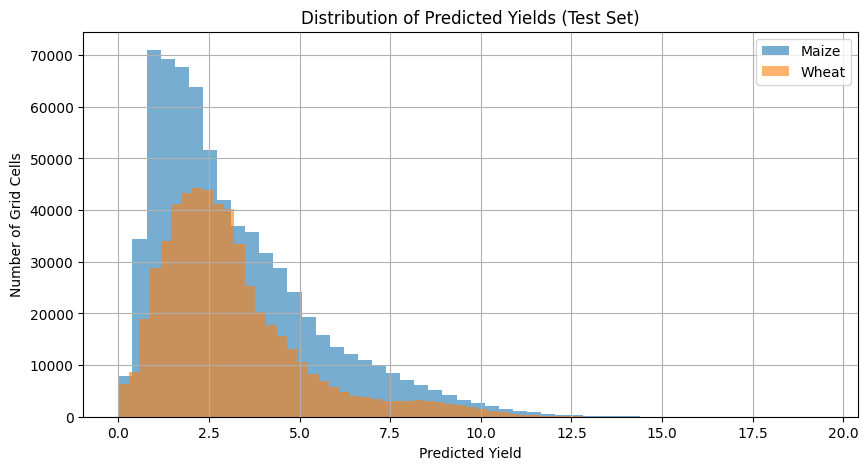

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(soil_test_maize['preds_yield'], bins=50, alpha=0.6, label='Maize')
plt.hist(soil_test_wheat['preds_yield'], bins=50, alpha=0.6, label='Wheat')
plt.xlabel('Predicted Yield')
plt.ylabel('Number of Grid Cells')
plt.title('Distribution of Predicted Yields (Test Set)')
plt.legend()
plt.grid(True)
plt.show()


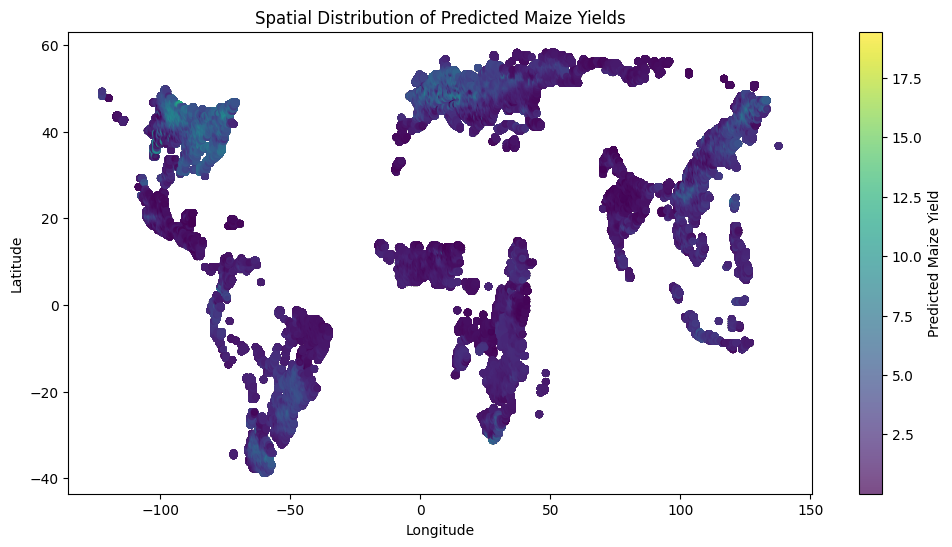

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(soil_test_maize['lon'], soil_test_maize['lat'],
            c=soil_test_maize['preds_yield'],  s=20, alpha=0.7)
plt.colorbar(label='Predicted Maize Yield')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Predicted Maize Yields')
plt.show()


In [ ]:
static_var=['nitrogen','texture_class','lon','lat','yield_mean','tas', 'tasmax', 'tasmin', 'pr', 'rsds']

# For Maize
_, _, maize_test_loader = get_training_dataloader(
    'maize', 'train', mypath,
    region=['USA', 'Other', 'South America', 'Europe'],
    static_var=static_var
)

# For Wheat
_, _, wheat_test_loader = get_training_dataloader(
    'wheat', 'train', mypath,
    region=['USA', 'Other', 'South America', 'Europe'],
    static_var=static_var
)


After region filtering: 349719 samples
Train: 306590, Val (2020): 9064, Test: 34065
After region filtering: 278747 samples
Train: 244413, Val (2020): 7178, Test: 27156


<ipython-input-40-4a12f61314c2>:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend()
<ipython-input-40-4a12f61314c2>:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 1].legend()


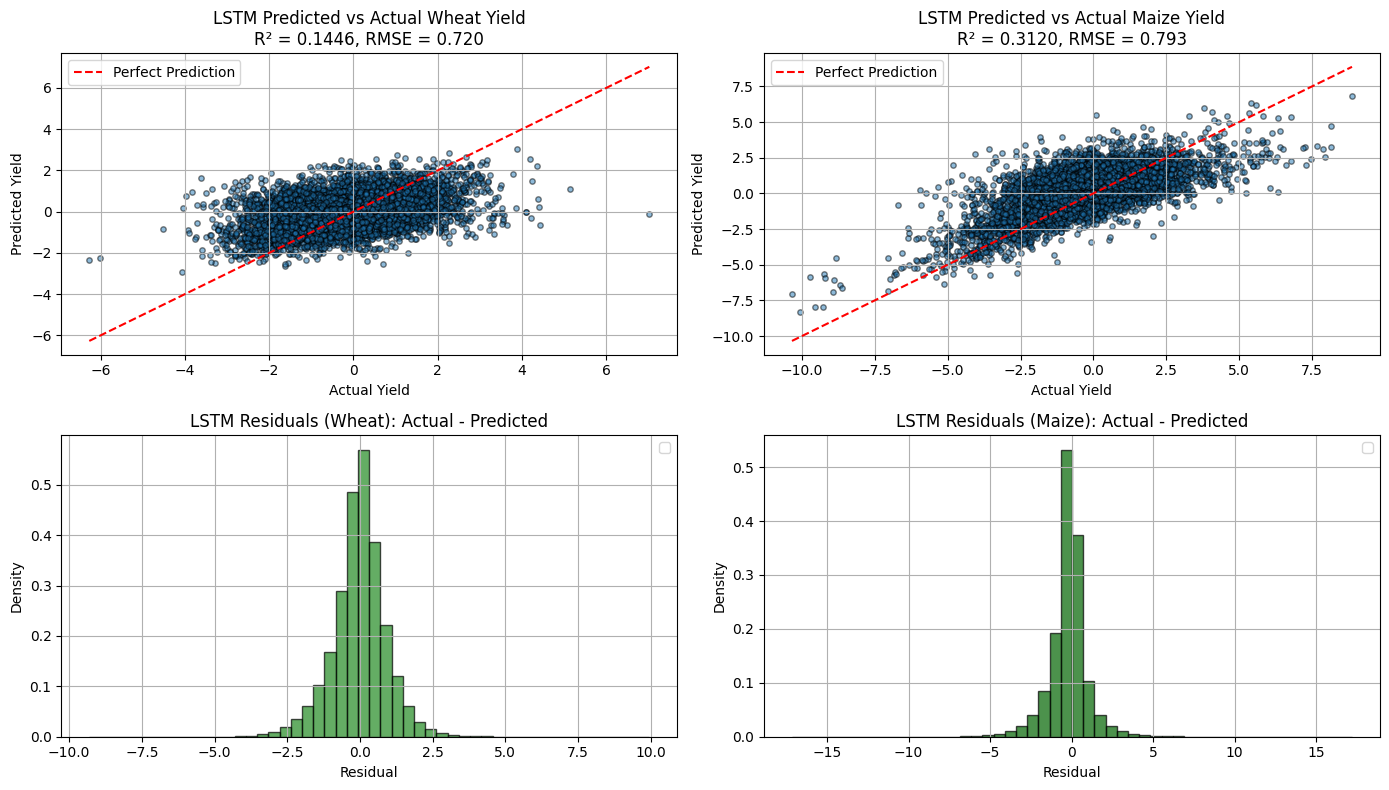

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_lstm(model, test_loader, title_prefix=""):
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, x_static, y_true in test_loader:
            y_pred = model(x.to(DEVICE), x_static.to(DEVICE)).cpu().numpy()
            y_true = y_true.cpu().numpy()
            y_true_all.append(y_true)
            y_pred_all.append(y_pred)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    residuals = y_true_all - y_pred_all
    r2 = r2_score(y_true_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

    return y_true_all, y_pred_all, residuals, r2, rmse

# --- Evaluate both models ---
y_true_wheat, y_pred_wheat, resid_wheat, r2_wheat, rmse_wheat = evaluate_lstm(wheat_unscale_model_GLOB2, wheat_test_loader, "Wheat")
y_true_maize, y_pred_maize, resid_maize, r2_maize, rmse_maize = evaluate_lstm(maize_unscale_model_GLOB, maize_test_loader, "Maize")

# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# 1. Wheat: Pred vs Actual
axs[0, 0].scatter(y_true_wheat, y_pred_wheat, alpha=0.5, s=15, edgecolor='k')
axs[0, 0].plot([y_true_wheat.min(), y_true_wheat.max()],
               [y_true_wheat.min(), y_true_wheat.max()],
               'r--', label='Perfect Prediction')
axs[0, 0].set_title(f'LSTM Predicted vs Actual Wheat Yield\nR² = {r2_wheat:.4f}, RMSE = {rmse_wheat:.3f}')
axs[0, 0].set_xlabel("Actual Yield")
axs[0, 0].set_ylabel("Predicted Yield")
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. Maize: Pred vs Actual
axs[0, 1].scatter(y_true_maize, y_pred_maize, alpha=0.5, s=15, edgecolor='k')
axs[0, 1].plot([y_true_maize.min(), y_true_maize.max()],
               [y_true_maize.min(), y_true_maize.max()],
               'r--', label='Perfect Prediction')
axs[0, 1].set_title(f'LSTM Predicted vs Actual Maize Yield\nR² = {r2_maize:.4f}, RMSE = {rmse_maize:.3f}')
axs[0, 1].set_xlabel("Actual Yield")
axs[0, 1].set_ylabel("Predicted Yield")
axs[0, 1].legend()
axs[0, 1].grid(True)

from scipy.stats import gaussian_kde

# 3.
resid_w = resid_wheat.ravel()
mean_w, std_w = np.mean(resid_w), np.std(resid_w)
x_w = np.linspace(resid_w.min(), resid_w.max(), 500)
pdf_w = (1 / (std_w * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_w - mean_w) / std_w) ** 2)

axs[1, 0].hist(resid_w, bins=50, color='forestgreen', edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('LSTM Residuals (Wheat): Actual - Predicted')
axs[1, 0].set_xlabel("Residual")
axs[1, 0].set_ylabel("Density")
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4.
resid_m = resid_maize.ravel()
mean_m, std_m = np.mean(resid_m), np.std(resid_m)
x_m = np.linspace(resid_m.min(), resid_m.max(), 500)
pdf_m = (1 / (std_m * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_m - mean_m) / std_m) ** 2)

axs[1, 1].hist(resid_m, bins=50, color='darkgreen', edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('LSTM Residuals (Maize): Actual - Predicted')
axs[1, 1].set_xlabel("Residual")
axs[1, 1].set_ylabel("Density")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()